1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


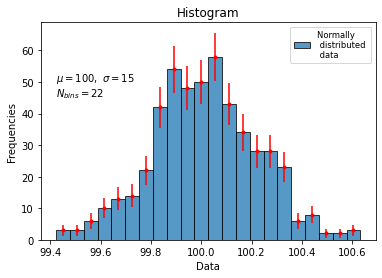

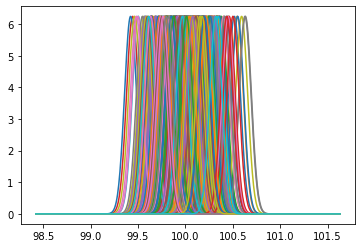

Integrale dell'istogramma 27.517218082178076
Integrale di gauss 500.0000000000001


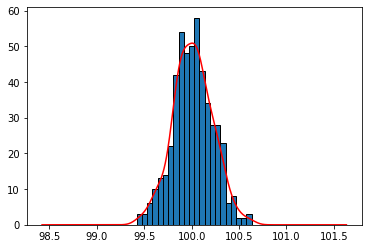

(array([ 3.,  3.,  6., 10., 13., 14., 22., 42., 54., 48., 50., 58., 43.,
        34., 28., 28., 23.,  6.,  8.,  2.,  2.,  3.]),
 array([ 99.42238858,  99.47742301,  99.53245745,  99.58749189,
         99.64252632,  99.69756076,  99.75259519,  99.80762963,
         99.86266407,  99.9176985 ,  99.97273294, 100.02776737,
        100.08280181, 100.13783625, 100.19287068, 100.24790512,
        100.30293956, 100.35797399, 100.41300843, 100.46804286,
        100.5230773 , 100.57811174, 100.63314617]),
 <BarContainer object of 22 artists>)

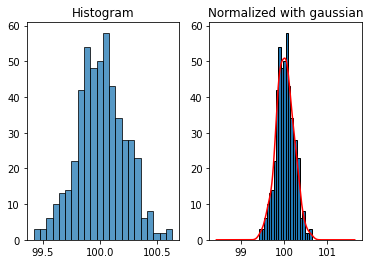

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

N=500
x = np.random.normal(loc=100, scale=0.2, size = N)
n_bins = int(np.sqrt(N))
# n_bins = 40
y, bin_edges, _ = plt.hist(x, n_bins, alpha=0.75, color='tab:blue', edgecolor='black')
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])

plt.errorbar(bin_centers, y, yerr=np.sqrt(y), fmt='r.')
plt.ylabel('Frequencies')
plt.xlabel('Data')
plt.legend(['Normally \n distributed \n data'], fontsize='small' )
plt.title('Histogram')
plt.text(x=min(x) , y=max(x)/2, s=r'$ \mu = 100, \ \sigma = 15$')
plt.text(x=min(x) , y=max(x)/2 -5, s=r'$ N_{bins} = 22$')

plt.show()

fig, ax = plt.subplots(1,1)

t = np.linspace(x.min()-1, x.max()+1, len(x))
std = 1.06 * x.std() * pow(x.size,-1/5)

p=[]
for i in range(len(x)):
    p.append(norm.pdf(t, loc=x[i], scale=std))
    pdf = norm.pdf(t, loc=x[i], scale=std)
    ax.plot(t, pdf)
p=np.asarray(p)

# p=norm.pdf(t,loc=x[0],scale=std)
# ax.plot(t,p)
# print(p[0])
plt.show()

from scipy import integrate

gauss_tot = np.sum(p,axis=0)

gauss_integral = integrate.trapz(gauss_tot, t)
hist_integral = np.sum(np.diff(bin_edges)*y)

print(f"Integrale dell'istogramma {hist_integral}")
print(f"Integrale di gauss {gauss_integral}")

norm_gauss = (hist_integral / gauss_integral) * gauss_tot
G = plt.plot(t,norm_gauss, color='red')
A = plt.hist(x, n_bins, color='tab:blue', edgecolor='black')
plt.show()

fig, (ax1,ax2) = plt.subplots(1,2)
ax1.set_title('Histogram')
ax2.set_title('Normalized with gaussian')
ax1.hist(x, n_bins, alpha=0.75, color='tab:blue', edgecolor='black')
ax2.plot(t,norm_gauss, color='red')
ax2.hist(x, n_bins, color='tab:blue', edgecolor='black')

2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

In [3]:
# ! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
# from IPython.display import Image
# Image('two_categories_scatter_plot.png')

<ipython-input-4-5c0d0246599e>:15: RuntimeWarning: covariance is not positive-semidefinite.
  data = np.random.multivariate_normal(mean, cov, N)


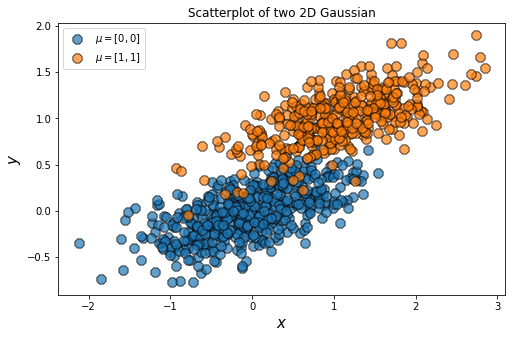

In [4]:
import pandas as pd
cov1 = [[0.3,0.2],[0.2,0.2]]
mean1 = [0,0]

cov2 = [[0.4,0.1],[0.2,0.1]]
mean2 = [1,1]

# data = np.random.multivariate_normal(mean, cov,1000)

# plt.scatter(data[:,0],data[:,1], 'o')
# plt.axis('equal')
# plt.show()

def f(mean, cov, N):
    data = np.random.multivariate_normal(mean, cov, N)
    return pd.DataFrame(data, columns=['x','y'])
df1 = f(mean1,cov2,500)
df2 = f(mean2, cov2, 400)

fig, ax = plt.subplots(figsize=(8,5))

ax.scatter(df1['x'], df1['y'], s=100, marker='8', alpha=0.7,  edgecolor='black', label='$\mu =[0,0]$')
ax.scatter(df2['x'], df2['y'], s=100, marker='8', alpha=0.7,  edgecolor='black', label='$\mu =[1,1] $')
ax.set_title('Scatterplot of two 2D Gaussian')
ax.set_xlabel('$x$',fontsize=15)
ax.set_ylabel('$y$',fontsize=15)
ax.legend()
plt.show()


3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should use the `np.load()` function to load the file as a numpy array, call the `.item()` method, and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

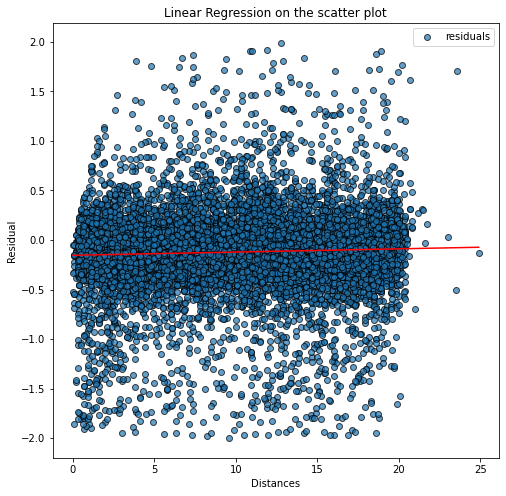

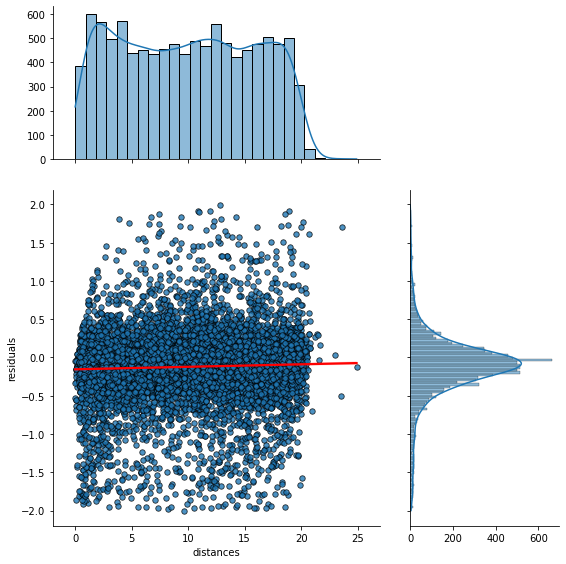

In [5]:
from scipy.stats import linregress
import seaborn as sns
data = np.load("residuals_261.npy", allow_pickle=True)
DF = pd.DataFrame(data.item())
df = DF[ abs(DF['residuals']) < 2]

slope, intercept, r, p, se = linregress(df['distances'],df['residuals'])

fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('Linear Regression on the scatter plot')
ax.set_xlabel('Distances')
ax.set_ylabel('Residual')
ax.scatter(x='distances',y='residuals', data=df, alpha=0.7,  edgecolor='black')

x=np.linspace(np.min(df['distances']), np.max(df['distances']), 100)
y=intercept + slope*x
ax.plot(x,y,c='red')
#label=f'y={slope}x + {intercept}')
ax.legend()
# sns.scatterplot(y='residuals', x='distances', data=df)
sns.jointplot(x='distances', y='residuals', data=df, kind='reg',ratio=2, xlim=(-2,27) , height=8, marginal_ticks=True, joint_kws={'line_kws':{'color':'red'},'scatter_kws':{'color':'tab:blue','edgecolors':'black', 's':30,'linewidths':0.8,'alpha':0.8}})



* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"

Another way to do it


<ErrorbarContainer object of 3 artists>

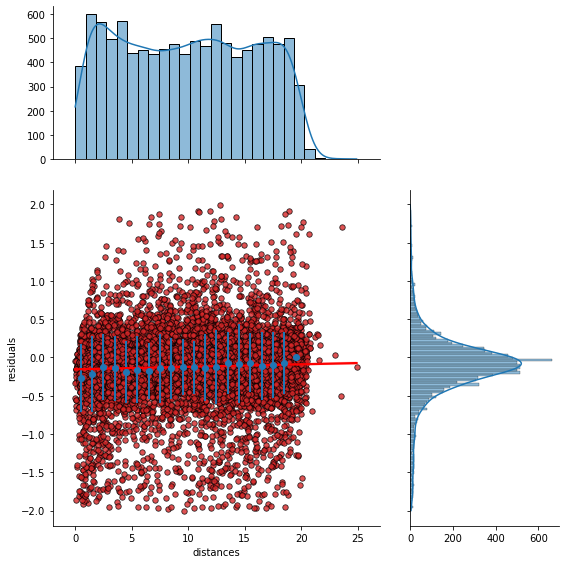

In [11]:
step=0.5
bin_centers = [i + step for i in range(20)] # x
y = np.zeros(len(bin_centers))
erry = np.zeros(len(bin_centers))

print('Another way to do it')
for i in range(len(bin_edges)-2):
    mask = ((df['distances']>=step*i) & (df['distances']<=step*(i+1)))
    dfi = df[mask]
    y[i] = dfi['residuals'].mean()
    erry[i] = dfi['residuals'].std()
p = sns.jointplot(x='distances', y='residuals', data=df, kind="reg", ratio=2, xlim=(-2,27) , height=8, marginal_ticks=True, joint_kws={'line_kws':{'color':'red'},'scatter_kws':{'color':'tab:red','edgecolors':'black', 's':30,'linewidths':0.8,'alpha':0.8}})
p.ax_joint.errorbar(bin_centers, y, erry, c='tab:blue', fmt='o', ecolor='tab:blue', label='Error bars', elinewidth=2)




Another way to do it is taking the bin centers directly from the histogram


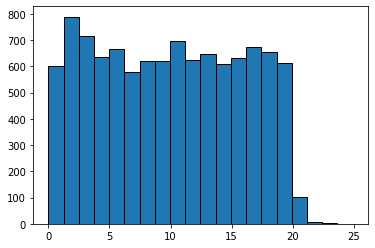

<ErrorbarContainer object of 3 artists>

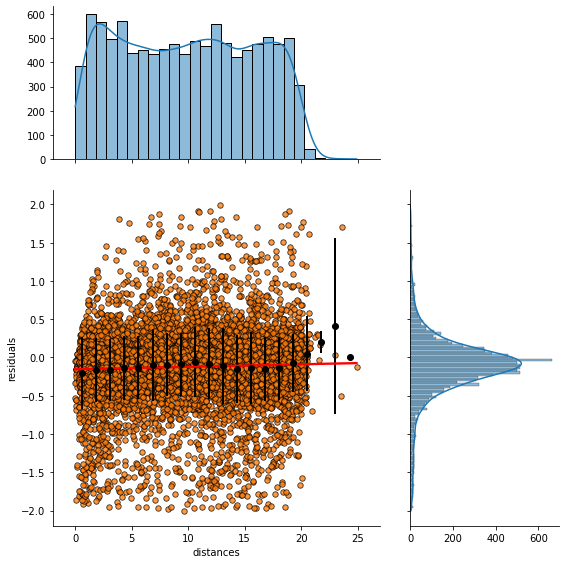

In [12]:
print('Another way to do it is taking the bin centers directly from the histogram')
bin = 20 
p, bin_edges, _ = plt.hist(df['distances'], bin, edgecolor='black' )
plt.show()
x = 0.5*(bin_edges[1:] + bin_edges[:-1]) #bin centers

y = np.zeros(len(bin_edges)-1)
erry = np.zeros(len(bin_edges)-1)

for i in range(len(bin_edges)-2):
    mask = ((df['distances']>=bin_edges[i]) & (df['distances']<=bin_edges[i+1]))
    # df.loc[(df['distances']>=bin_edges[i]) & (df['distances']<=bin_edges[i+1])]
    dfi = df[mask]
    y[i] = dfi['residuals'].mean()
    erry[i] = dfi['residuals'].std()
    # v[i] = (dfi.groupby(by='residuals').mean())
# print(y)
# print(erry)
p = sns.jointplot(x='distances', y='residuals', data=df, kind="reg", ratio=2, xlim=(-2,27) , height=8, marginal_ticks=True, joint_kws={'line_kws':{'color':'red'},'scatter_kws':{'color':'tab:orange','edgecolors':'black', 's':30,'linewidths':0.8,'alpha':0.8}})
p.ax_joint.errorbar(x, y, erry, c='black', fmt='o', ecolor='black', label='Error bars', elinewidth=2)